# COMP647 Assignment 03 - Machine Learning Pipeline
## Lending Club Loan Default Prediction
### Student ID: 1163127

This comprehensive notebook integrates all Assignment 03 work including:
- Feature Engineering
- Feature Selection
- Machine Learning Models
- Model Evaluation
- Explainable AI

---

## Table of Contents
1. [Part 1: Feature Engineering](#part1)
   - [1.1 Categorical Encoding](#part1-1)
   - [1.2 Feature Scaling](#part1-2)
   - [1.3 Complete Pipeline](#part1-3)

2. [Part 2: Feature Selection](#part2)
   - [2.1 Univariate Statistical Tests](#part2-1)
   - [2.2 Wrapper Methods](#part2-2)
   - [2.3 Embedded Methods](#part2-3)

3. [Part 3: Machine Learning Models](#part3)
   - [3.1 Logistic Regression](#part3-1)
   - [3.2 Random Forest](#part3-2)
   - [3.3 Gradient Boosting](#part3-3)

4. [Part 4: Model Evaluation](#part4)
   - [4.1 Performance Metrics](#part4-1)
   - [4.2 Cross-Validation](#part4-2)
   - [4.3 Learning Curves](#part4-3)

5. [Part 5: Explainable AI](#part5)
   - [5.1 Feature Importance](#part5-1)
   - [5.2 Permutation Importance](#part5-2)
   - [5.3 Decision Trees & Partial Dependence](#part5-3)

---

<a id="part1"></a>
# Part 1: Feature Engineering

Feature engineering transforms raw data into features that better represent patterns for machine learning algorithms. This section covers:
- **Categorical Encoding**: Label Encoding, One-Hot Encoding, Binary Encoding
- **Feature Scaling**: Min-Max Scaling, Standard Scaling
- **Class Imbalance**: SMOTE for handling imbalanced datasets
- **Complete Pipeline**: Integrated transformation workflow

In [2]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

print("Libraries imported successfully")

Libraries imported successfully


In [3]:
# Load preprocessed data from Assignment 02
try:
    # Load the processed sample data
    df = pd.read_csv('../data/processed/accepted_sample_10000.csv')
    print(f"Data loaded successfully: {df.shape}")
    print(f"Columns: {len(df.columns)}")
except FileNotFoundError:
    print("Processed data not found. Please run Assignment 02 notebooks first.")
    df = pd.DataFrame()

# Display basic info about the dataset
if not df.empty:
    print("\nDataset Info:")
    print(df.info())
    
    # Identify categorical and numerical features
    categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
    
    print(f"\nCategorical features: {len(categorical_features)}")
    print(f"Numerical features: {len(numerical_features)}")
    
    if categorical_features:
        print("\nSample categorical features:")
        for col in categorical_features[:5]:  # Show first 5
            print(f"  {col}: {df[col].nunique()} unique values")

Data loaded successfully: (10000, 151)
Columns: 151

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 151 entries, id to settlement_term
dtypes: float64(114), int64(1), object(36)
memory usage: 11.5+ MB
None

Categorical features: 36
Numerical features: 115

Sample categorical features:
  term: 2 unique values
  grade: 7 unique values
  sub_grade: 35 unique values
  emp_title: 5622 unique values
  emp_length: 11 unique values


<a id="part1-1"></a>
## 1.1 Categorical Encoding Methods

Machine learning algorithms require numerical inputs. We implement three encoding methods:

### Label Encoding
- Assigns unique integers to categories (0, 1, 2, ...)
- Best for ordinal categorical variables
- Introduces artificial ordering

### One-Hot Encoding
- Creates binary columns for each category
- Best for nominal categorical variables
- Prevents artificial ordering but increases dimensionality

### Binary Encoding
- Converts categories to binary representation
- Efficient for high cardinality features
- Reduces dimensionality compared to one-hot

In [4]:
# Label Encoding Implementation
from sklearn.preprocessing import LabelEncoder

def apply_label_encoding(df, categorical_columns):
    """
    Apply label encoding to categorical features
    
    Parameters:
    df: DataFrame with categorical features
    categorical_columns: list of column names to encode
    
    Returns:
    df_encoded: DataFrame with label encoded features
    encoders: dict of fitted encoders for inverse transform
    """
    df_encoded = df.copy()
    encoders = {}
    
    print("Applying Label Encoding...")
    for col in categorical_columns:
        if col in df_encoded.columns:
            le = LabelEncoder()
            df_encoded[col] = df_encoded[col].fillna('Unknown')
            df_encoded[col + '_encoded'] = le.fit_transform(df_encoded[col])
            encoders[col] = le
            print(f"  {col}: {len(le.classes_)} unique values -> 0 to {len(le.classes_)-1}")
    
    return df_encoded, encoders

# Example usage
if not df.empty and categorical_features:
    sample_categorical = categorical_features[:3] if len(categorical_features) >= 3 else categorical_features
    print(f"Demonstrating Label Encoding on: {sample_categorical}")
    df_label_encoded, label_encoders = apply_label_encoding(df, sample_categorical)
    
    # Show before and after comparison
    for col in sample_categorical:
        if col in df.columns:
            print(f"\n{col} - Original vs Encoded:")
            comparison = pd.DataFrame({
                'Original': df[col].head(10),
                'Encoded': df_label_encoded[col + '_encoded'].head(10)
            })
            print(comparison)

Demonstrating Label Encoding on: ['term', 'grade', 'sub_grade']
Applying Label Encoding...
  term: 2 unique values -> 0 to 1
  grade: 7 unique values -> 0 to 6
  sub_grade: 35 unique values -> 0 to 34

term - Original vs Encoded:
     Original  Encoded
0   36 months        0
1   36 months        0
2   60 months        1
3   60 months        1
4   60 months        1
5   36 months        0
6   36 months        0
7   36 months        0
8   36 months        0
9   36 months        0

grade - Original vs Encoded:
  Original  Encoded
0        C        2
1        C        2
2        B        1
3        C        2
4        F        5
5        C        2
6        B        1
7        B        1
8        A        0
9        B        1

sub_grade - Original vs Encoded:
  Original  Encoded
0       C4       13
1       C1       10
2       B4        8
3       C5       14
4       F1       25
5       C3       12
6       B2        6
7       B1        5
8       A2        1
9       B5        9


In [5]:
# One-Hot Encoding Implementation
def apply_onehot_encoding(df, categorical_columns, drop_first=True, max_categories=10):
    """
    Apply one-hot encoding to categorical features
    
    Parameters:
    df: DataFrame with categorical features  
    categorical_columns: list of column names to encode
    drop_first: whether to drop first category to avoid multicollinearity
    max_categories: maximum unique values to consider for encoding
    
    Returns:
    df_encoded: DataFrame with one-hot encoded features
    """
    df_encoded = df.copy()
    
    print("Applying One-Hot Encoding...")
    for col in categorical_columns:
        if col in df_encoded.columns:
            n_categories = df_encoded[col].nunique()
            
            if n_categories <= max_categories:
                dummies = pd.get_dummies(df_encoded[col], prefix=col, drop_first=drop_first)
                df_encoded = pd.concat([df_encoded, dummies], axis=1)
                print(f"  {col}: {n_categories} categories -> {len(dummies.columns)} dummy columns")
            else:
                print(f"  {col}: Skipped ({n_categories} categories > {max_categories} threshold)")
    
    return df_encoded

# Example usage
if not df.empty and categorical_features:
    suitable_features = [col for col in categorical_features[:3] 
                        if col in df.columns and df[col].nunique() <= 10]
    
    if suitable_features:
        print(f"Demonstrating One-Hot Encoding on: {suitable_features}")
        df_onehot_encoded = apply_onehot_encoding(df, suitable_features)
        
        for col in suitable_features:
            dummy_cols = [c for c in df_onehot_encoded.columns if c.startswith(col + '_')]
            if dummy_cols:
                print(f"\n{col} dummy columns: {dummy_cols}")
                print(f"Sample values:")
                print(df_onehot_encoded[dummy_cols].head())

Demonstrating One-Hot Encoding on: ['term', 'grade']
Applying One-Hot Encoding...
  term: 2 categories -> 1 dummy columns
  grade: 7 categories -> 6 dummy columns

term dummy columns: ['term_ 60 months']
Sample values:
   term_ 60 months
0            False
1            False
2             True
3             True
4             True

grade dummy columns: ['grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G']
Sample values:
   grade_B  grade_C  grade_D  grade_E  grade_F  grade_G
0    False     True    False    False    False    False
1    False     True    False    False    False    False
2     True    False    False    False    False    False
3    False     True    False    False    False    False
4    False    False    False    False     True    False


In [6]:
# Binary Encoding Implementation
import category_encoders as ce

def apply_binary_encoding(df, categorical_columns):
    """
    Apply binary encoding for high cardinality categorical features
    
    Parameters:
    df: DataFrame with categorical features
    categorical_columns: list of column names to encode
    
    Returns:
    df_encoded: DataFrame with binary encoded features
    encoder: fitted binary encoder
    """
    df_encoded = df.copy()
    
    print("Applying Binary Encoding...")
    print("Binary encoding reduces dimensionality compared to one-hot encoding")
    print("Example: 8 categories need only 3 binary columns (2^3 = 8)")
    
    for col in categorical_columns:
        if col in df_encoded.columns:
            df_encoded[col] = df_encoded[col].fillna('Unknown')
            encoder = ce.BinaryEncoder(cols=[col])
            encoded_cols = encoder.fit_transform(df_encoded[[col]])
            
            for encoded_col in encoded_cols.columns:
                df_encoded[f"{col}_bin_{encoded_col}"] = encoded_cols[encoded_col]
            
            n_categories = df_encoded[col].nunique()
            n_binary_cols = len(encoded_cols.columns)
            print(f"  {col}: {n_categories} categories -> {n_binary_cols} binary columns")
    
    return df_encoded, encoder

# Example usage
if not df.empty and categorical_features:
    high_cardinality = [col for col in categorical_features 
                       if col in df.columns and 5 < df[col].nunique() <= 50]
    
    if high_cardinality:
        demo_feature = high_cardinality[0]
        print(f"Demonstrating Binary Encoding on: {demo_feature}")
        df_binary_encoded, binary_encoder = apply_binary_encoding(df, [demo_feature])
        
        binary_cols = [c for c in df_binary_encoded.columns if c.startswith(demo_feature + '_bin_')]
        print(f"\nDimensionality comparison:")
        print(f"  One-hot would create: {df[demo_feature].nunique()} columns")  
        print(f"  Binary encoding creates: {len(binary_cols)} columns")
        print(f"  Space savings: {((df[demo_feature].nunique() - len(binary_cols)) / df[demo_feature].nunique() * 100):.1f}%")

Demonstrating Binary Encoding on: grade
Applying Binary Encoding...
Binary encoding reduces dimensionality compared to one-hot encoding
Example: 8 categories need only 3 binary columns (2^3 = 8)
  grade: 7 categories -> 3 binary columns

Dimensionality comparison:
  One-hot would create: 7 columns
  Binary encoding creates: 3 columns
  Space savings: 57.1%


<a id="part1-2"></a>
## 1.2 Feature Scaling Methods

Feature scaling ensures features contribute equally to model training:

### Min-Max Scaling
- Scales features to [0, 1] range
- Formula: (x - min) / (max - min)
- Preserves relationships between values
- Sensitive to outliers

### Standard Scaling (Z-score Normalization)
- Centers features at mean=0, std=1
- Formula: (x - mean) / std
- Less sensitive to outliers
- Assumes approximately normal distribution

Demonstrating Min-Max Scaling on: 9 features
Applying Min-Max Scaling...
Scaling numerical features to range (0, 1)
Scaled 9 numerical features:
  id: [361774.00, 68617057.00] -> [0.00, 1.00]
  loan_amnt: [1000.00, 35000.00] -> [0.00, 1.00]
  funded_amnt: [1000.00, 35000.00] -> [0.00, 1.00]
  funded_amnt_inv: [1000.00, 35000.00] -> [0.00, 1.00]
  int_rate: [5.32, 28.99] -> [0.00, 1.00]
  ... and 4 more features


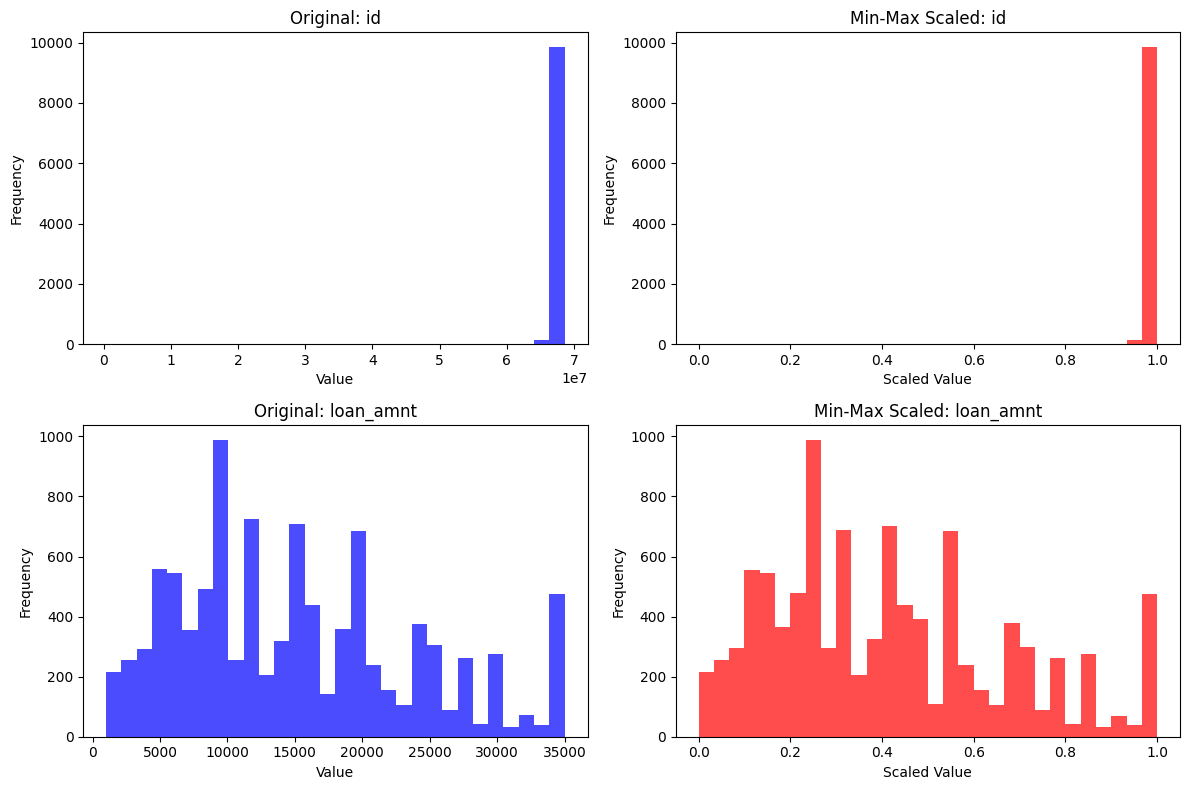

In [7]:
# Min-Max Scaling Implementation
from sklearn.preprocessing import MinMaxScaler

def apply_minmax_scaling(df, numerical_columns, feature_range=(0, 1)):
    """
    Apply Min-Max scaling to numerical features
    
    Parameters:
    df: DataFrame with numerical features
    numerical_columns: list of column names to scale
    feature_range: tuple defining the target range
    
    Returns:
    df_scaled: DataFrame with scaled features
    scaler: fitted MinMaxScaler
    """
    df_scaled = df.copy()
    
    print("Applying Min-Max Scaling...")
    print(f"Scaling numerical features to range {feature_range}")
    
    if numerical_columns:
        scaler = MinMaxScaler(feature_range=feature_range)
        valid_columns = [col for col in numerical_columns if col in df_scaled.columns]
        
        if valid_columns:
            df_scaled[valid_columns] = scaler.fit_transform(df_scaled[valid_columns])
            
            print(f"Scaled {len(valid_columns)} numerical features:")
            for col in valid_columns[:5]:
                original_min = df[col].min()
                original_max = df[col].max()
                scaled_min = df_scaled[col].min()
                scaled_max = df_scaled[col].max()
                print(f"  {col}: [{original_min:.2f}, {original_max:.2f}] -> [{scaled_min:.2f}, {scaled_max:.2f}]")
            
            if len(valid_columns) > 5:
                print(f"  ... and {len(valid_columns) - 5} more features")
        else:
            scaler = None
    else:
        scaler = None
    
    return df_scaled, scaler

# Example usage
if not df.empty and numerical_features:
    sample_numerical = [col for col in numerical_features[:10] 
                       if col in df.columns and not col.lower().endswith('_id') and df[col].nunique() > 2]
    
    if sample_numerical:
        print(f"Demonstrating Min-Max Scaling on: {len(sample_numerical)} features")
        df_minmax_scaled, minmax_scaler = apply_minmax_scaling(df, sample_numerical)
        
        if len(sample_numerical) >= 2:
            fig, axes = plt.subplots(2, 2, figsize=(12, 8))
            
            for i, col in enumerate(sample_numerical[:2]):
                axes[i, 0].hist(df[col].dropna(), bins=30, alpha=0.7, color='blue')
                axes[i, 0].set_title(f'Original: {col}')
                axes[i, 0].set_xlabel('Value')
                axes[i, 0].set_ylabel('Frequency')
                
                axes[i, 1].hist(df_minmax_scaled[col].dropna(), bins=30, alpha=0.7, color='red')
                axes[i, 1].set_title(f'Min-Max Scaled: {col}')
                axes[i, 1].set_xlabel('Scaled Value')
                axes[i, 1].set_ylabel('Frequency')
            
            plt.tight_layout()
            plt.show()

Demonstrating Standard Scaling on: 9 features
Applying Standard Scaling...
Standardizing numerical features to mean=0, std=1
Standardized 9 numerical features:
  id: mean 68040547.84±1974649.77 -> -0.00±1.00
  loan_amnt: mean 15104.44±8717.53 -> -0.00±1.00
  funded_amnt: mean 15104.44±8717.53 -> -0.00±1.00
  funded_amnt_inv: mean 15100.90±8714.50 -> -0.00±1.00
  int_rate: mean 12.30±4.30 -> 0.00±1.00
  ... and 4 more features


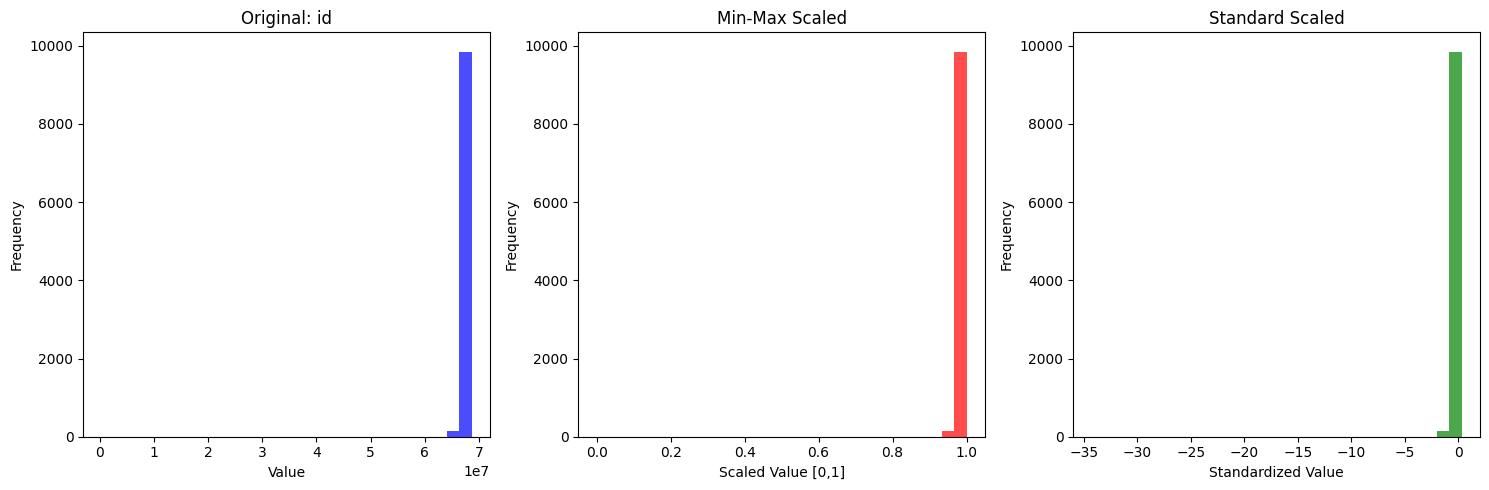


Scaling Statistics for id:
Original: mean=68040547.84, std=1974649.77
Min-Max:  min=0.00, max=1.00
Standard: mean=-0.00, std=1.00


In [8]:
# Standard Scaling Implementation
from sklearn.preprocessing import StandardScaler

def apply_standard_scaling(df, numerical_columns):
    """
    Apply Standard scaling (Z-score normalization)
    
    Parameters:
    df: DataFrame with numerical features
    numerical_columns: list of column names to scale
    
    Returns:
    df_scaled: DataFrame with standardized features
    scaler: fitted StandardScaler
    """
    df_scaled = df.copy()
    
    print("Applying Standard Scaling...")
    print("Standardizing numerical features to mean=0, std=1")
    
    if numerical_columns:
        scaler = StandardScaler()
        valid_columns = [col for col in numerical_columns if col in df_scaled.columns]
        
        if valid_columns:
            df_scaled[valid_columns] = scaler.fit_transform(df_scaled[valid_columns])
            
            print(f"Standardized {len(valid_columns)} numerical features:")
            for col in valid_columns[:5]:
                original_mean = df[col].mean()
                original_std = df[col].std()
                scaled_mean = df_scaled[col].mean()
                scaled_std = df_scaled[col].std()
                print(f"  {col}: mean {original_mean:.2f}±{original_std:.2f} -> {scaled_mean:.2f}±{scaled_std:.2f}")
            
            if len(valid_columns) > 5:
                print(f"  ... and {len(valid_columns) - 5} more features")
        else:
            scaler = None
    else:
        scaler = None
    
    return df_scaled, scaler

# Compare scaling methods
if not df.empty and numerical_features:
    sample_numerical = [col for col in numerical_features[:10]
                       if col in df.columns and not col.lower().endswith('_id') and df[col].nunique() > 2]
    
    if sample_numerical:
        print(f"Demonstrating Standard Scaling on: {len(sample_numerical)} features")
        df_standard_scaled, standard_scaler = apply_standard_scaling(df, sample_numerical)
        
        if len(sample_numerical) >= 1:
            comparison_feature = sample_numerical[0]
            
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            
            axes[0].hist(df[comparison_feature].dropna(), bins=30, alpha=0.7, color='blue')
            axes[0].set_title(f'Original: {comparison_feature}')
            axes[0].set_xlabel('Value')
            axes[0].set_ylabel('Frequency')
            
            if 'df_minmax_scaled' in locals():
                axes[1].hist(df_minmax_scaled[comparison_feature].dropna(), bins=30, alpha=0.7, color='red')
                axes[1].set_title(f'Min-Max Scaled')
                axes[1].set_xlabel('Scaled Value [0,1]')
                axes[1].set_ylabel('Frequency')
            
            axes[2].hist(df_standard_scaled[comparison_feature].dropna(), bins=30, alpha=0.7, color='green')
            axes[2].set_title(f'Standard Scaled')
            axes[2].set_xlabel('Standardized Value')
            axes[2].set_ylabel('Frequency')
            
            plt.tight_layout()
            plt.show()
            
            print(f"\nScaling Statistics for {comparison_feature}:")
            print(f"Original: mean={df[comparison_feature].mean():.2f}, std={df[comparison_feature].std():.2f}")
            if 'df_minmax_scaled' in locals():
                print(f"Min-Max:  min={df_minmax_scaled[comparison_feature].min():.2f}, max={df_minmax_scaled[comparison_feature].max():.2f}")
            print(f"Standard: mean={df_standard_scaled[comparison_feature].mean():.2f}, std={df_standard_scaled[comparison_feature].std():.2f}")

<a id="part1-3"></a>
## 1.3 Complete Feature Engineering Pipeline

Integration of all feature engineering techniques into a configurable pipeline

In [9]:
# Complete Feature Engineering Pipeline
def feature_engineering_pipeline(df, config=None):
    """
    Complete feature engineering pipeline
    
    Parameters:
    df: input DataFrame
    config: configuration dict with encoding/scaling preferences
    
    Returns:
    df_processed: fully processed DataFrame
    pipeline_info: information about transformations
    encoders: dict of fitted encoders
    """
    if config is None:
        config = {
            'categorical_encoding': 'auto',
            'numerical_scaling': 'standard',
            'handle_missing': True,
            'target_column': None
        }
    
    print("=== Feature Engineering Pipeline ===")
    print(f"Input data shape: {df.shape}")
    
    df_processed = df.copy()
    pipeline_info = {
        'original_shape': df.shape,
        'categorical_features': [],
        'numerical_features': [],
        'transformations_applied': [],
        'final_shape': None
    }
    encoders = {}
    
    # Identify feature types
    categorical_features = df_processed.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_features = df_processed.select_dtypes(include=[np.number]).columns.tolist()
    
    if config['target_column']:
        if config['target_column'] in numerical_features:
            numerical_features.remove(config['target_column'])
        if config['target_column'] in categorical_features:
            categorical_features.remove(config['target_column'])
    
    pipeline_info['categorical_features'] = categorical_features
    pipeline_info['numerical_features'] = numerical_features
    
    print(f"Categorical features: {len(categorical_features)}")
    print(f"Numerical features: {len(numerical_features)}")
    
    # Step 1: Handle missing values
    if config['handle_missing']:
        print("\nStep 1: Handling missing values...")
        for col in categorical_features:
            if df_processed[col].isnull().any():
                df_processed[col] = df_processed[col].fillna('Unknown')
        
        for col in numerical_features:
            if df_processed[col].isnull().any():
                df_processed[col] = df_processed[col].fillna(df_processed[col].mean())
        
        pipeline_info['transformations_applied'].append('missing_value_imputation')
    
    # Step 2: Categorical encoding
    if categorical_features:
        print(f"\nStep 2: Categorical encoding ({config['categorical_encoding']})...")
        
        if config['categorical_encoding'] == 'auto':
            for col in categorical_features:
                n_unique = df_processed[col].nunique()
                if n_unique == 2:
                    df_processed, col_encoders = apply_label_encoding(df_processed, [col])
                    encoders.update(col_encoders)
                elif n_unique <= 10:
                    df_processed = apply_onehot_encoding(df_processed, [col])
                else:
                    df_processed, col_encoder = apply_binary_encoding(df_processed, [col])
                    encoders[col] = col_encoder
        
        pipeline_info['transformations_applied'].append(f"categorical_encoding_{config['categorical_encoding']}")
    
    # Step 3: Numerical scaling
    if numerical_features and config['numerical_scaling'] != 'none':
        print(f"\nStep 3: Numerical scaling ({config['numerical_scaling']})...")
        
        if config['numerical_scaling'] == 'standard':
            df_processed, scaler = apply_standard_scaling(df_processed, numerical_features)
            encoders['numerical_scaler'] = scaler
        elif config['numerical_scaling'] == 'minmax':
            df_processed, scaler = apply_minmax_scaling(df_processed, numerical_features)
            encoders['numerical_scaler'] = scaler
        
        pipeline_info['transformations_applied'].append(f"numerical_scaling_{config['numerical_scaling']}")
    
    pipeline_info['final_shape'] = df_processed.shape
    
    print(f"\n=== Pipeline Complete ===")
    print(f"Final data shape: {df_processed.shape}")
    print(f"Transformations: {', '.join(pipeline_info['transformations_applied'])}")
    
    return df_processed, pipeline_info, encoders

# Example usage
if not df.empty:
    print("Demonstrating Complete Feature Engineering Pipeline")
    
    pipeline_config = {
        'categorical_encoding': 'auto',
        'numerical_scaling': 'standard',
        'handle_missing': True,
        'target_column': 'loan_status' if 'loan_status' in df.columns else None
    }
    
    df_final, info, all_encoders = feature_engineering_pipeline(df, pipeline_config)
    
    print(f"\nPipeline Results:")
    print(f"Original features: {info['original_shape'][1]}")
    print(f"Final features: {info['final_shape'][1]}")
    print(f"Feature expansion: {info['final_shape'][1] - info['original_shape'][1]} new features")

Demonstrating Complete Feature Engineering Pipeline
=== Feature Engineering Pipeline ===
Input data shape: (10000, 151)
Categorical features: 35
Numerical features: 115

Step 1: Handling missing values...

Step 2: Categorical encoding (auto)...
Applying Label Encoding...
  term: 2 unique values -> 0 to 1
Applying One-Hot Encoding...
  grade: 7 categories -> 6 dummy columns
Applying Binary Encoding...
Binary encoding reduces dimensionality compared to one-hot encoding
Example: 8 categories need only 3 binary columns (2^3 = 8)
  sub_grade: 35 categories -> 6 binary columns
Applying Binary Encoding...
Binary encoding reduces dimensionality compared to one-hot encoding
Example: 8 categories need only 3 binary columns (2^3 = 8)
  emp_title: 5623 categories -> 13 binary columns
Applying Binary Encoding...
Binary encoding reduces dimensionality compared to one-hot encoding
Example: 8 categories need only 3 binary columns (2^3 = 8)
  emp_length: 12 categories -> 4 binary columns
Applying One-H

---
<a id="part2"></a>
# Part 2: Feature Selection

Feature selection identifies the most relevant features for model training:
- **Reduces overfitting** by removing irrelevant features
- **Improves training speed** with fewer dimensions
- **Enhances interpretability** by focusing on key features

We implement three types of feature selection methods:
1. **Univariate Statistical Tests** (filter methods)
2. **Wrapper Methods** (RFE)
3. **Embedded Methods** (Random Forest importance)

In [10]:
# Import feature selection libraries
from sklearn.feature_selection import (
    SelectKBest, f_classif, chi2, 
    RFE, RFECV,
    SelectFromModel
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

print("Feature selection libraries imported successfully")

Feature selection libraries imported successfully


<a id="part2-1"></a>
## 2.1 Univariate Statistical Tests

### ANOVA F-test
- Tests relationship between numerical features and categorical target
- Measures variance between groups vs within groups
- Higher F-score indicates stronger relationship

### Chi-Square Test
- Tests independence between categorical features and target
- Measures difference between observed and expected frequencies
- Higher chi-square score indicates stronger dependency

Applying ANOVA F-test for numerical features...
Selected 10 features

Top 5 features:
  int_rate: F-score = 245.51
  loan_amnt: F-score = 109.04
  funded_amnt: F-score = 109.04
  funded_amnt_inv: F-score = 109.04
  fico_range_low: F-score = 36.99


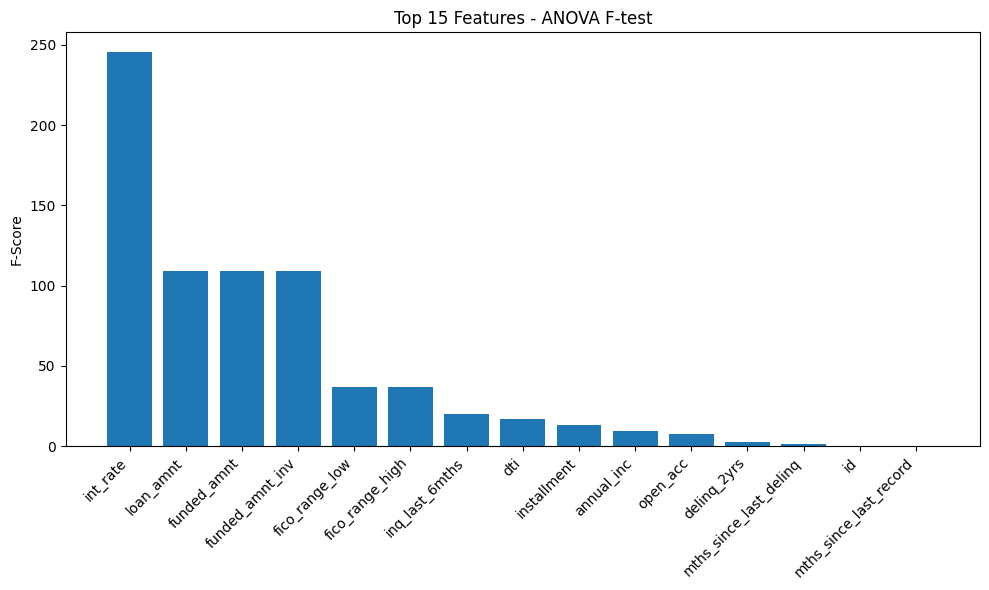

In [11]:
# ANOVA F-test Implementation
def apply_anova_ftest(X, y, k=10):
    """
    Apply ANOVA F-test for feature selection
    
    Parameters:
    X: DataFrame with numerical features
    y: target variable
    k: number of top features to select
    
    Returns:
    selected_features, results_df, selector
    """
    print("Applying ANOVA F-test for numerical features...")
    
    selector = SelectKBest(score_func=f_classif, k=min(k, X.shape[1]))
    selector.fit(X, y)
    
    results_df = pd.DataFrame({
        'feature': X.columns,
        'f_score': selector.scores_,
        'selected': selector.get_support()
    }).sort_values('f_score', ascending=False)
    
    selected_features = results_df[results_df['selected']]['feature'].tolist()
    
    print(f"Selected {len(selected_features)} features")
    print("\nTop 5 features:")
    for idx, row in results_df.head(5).iterrows():
        print(f"  {row['feature']}: F-score = {row['f_score']:.2f}")
    
    return selected_features, results_df, selector

# Apply ANOVA
if not df.empty and 'loan_status' in df.columns:
    num_features = df.select_dtypes(include=[np.number]).columns.tolist()
    num_features = [c for c in num_features if c != 'loan_status' and not c.endswith('_id')][:15]
    
    if len(num_features) >= 5:
        X_num = df[num_features].fillna(df[num_features].mean())
        le = LabelEncoder()
        y = le.fit_transform(df['loan_status'].fillna('Unknown'))
        
        sel_anova, anova_results, anova_sel = apply_anova_ftest(X_num, y, k=10)
        
        plt.figure(figsize=(10, 6))
        top15 = anova_results.head(15)
        plt.bar(range(len(top15)), top15['f_score'])
        plt.xticks(range(len(top15)), top15['feature'], rotation=45, ha='right')
        plt.title('Top 15 Features - ANOVA F-test')
        plt.ylabel('F-Score')
        plt.tight_layout()
        plt.show()

Applying Chi-Square test for categorical features...
Selected 5 features

Top features:
  emp_title: Chi2 = 15800.32
  url: Chi2 = 7883.90
  sub_grade: Chi2 = 4250.53
  term: Chi2 = 2200.08
  grade: Chi2 = 993.18


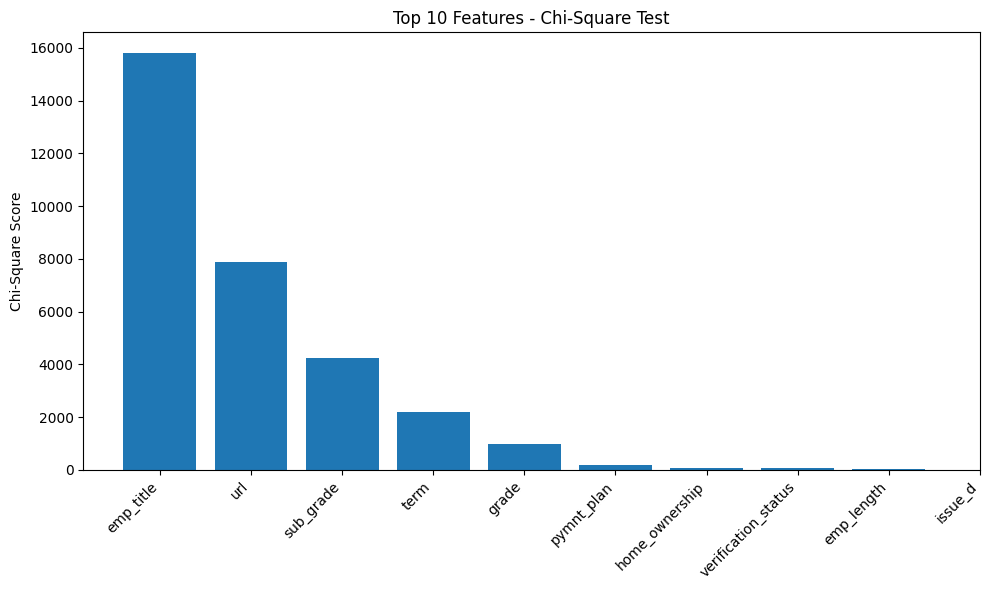

In [12]:
# Chi-Square Test Implementation
def apply_chi_square(X, y, k=5):
    """Apply Chi-Square test for categorical features"""
    print("Applying Chi-Square test for categorical features...")
    
    selector = SelectKBest(score_func=chi2, k=min(k, X.shape[1]))
    selector.fit(X, y)
    
    results_df = pd.DataFrame({
        'feature': X.columns,
        'chi2_score': selector.scores_,
        'selected': selector.get_support()
    }).sort_values('chi2_score', ascending=False)
    
    selected_features = results_df[results_df['selected']]['feature'].tolist()
    
    print(f"Selected {len(selected_features)} features")
    print("\nTop features:")
    for idx, row in results_df.head(5).iterrows():
        print(f"  {row['feature']}: Chi2 = {row['chi2_score']:.2f}")
    
    return selected_features, results_df, selector

# Apply Chi-Square
if not df.empty and 'loan_status' in df.columns:
    cat_features = df.select_dtypes(include=['object']).columns.tolist()
    if 'loan_status' in cat_features:
        cat_features.remove('loan_status')
    
    if len(cat_features) >= 3:
        X_cat = df[cat_features[:10]].copy()
        for col in X_cat.columns:
            le = LabelEncoder()
            X_cat[col] = le.fit_transform(X_cat[col].fillna('Unknown'))
        
        le = LabelEncoder()
        y = le.fit_transform(df['loan_status'].fillna('Unknown'))
        
        sel_chi, chi_results, chi_sel = apply_chi_square(X_cat, y, k=5)
        
        plt.figure(figsize=(10, 6))
        top10 = chi_results.head(10)
        plt.bar(range(len(top10)), top10['chi2_score'])
        plt.xticks(range(len(top10)), top10['feature'], rotation=45, ha='right')
        plt.title('Top 10 Features - Chi-Square Test')
        plt.ylabel('Chi-Square Score')
        plt.tight_layout()
        plt.show()

<a id="part2-2"></a>
## 2.2 Wrapper Methods - Recursive Feature Elimination (RFE)

RFE recursively removes features and builds models:
- Trains model with all features
- Removes least important feature
- Repeats until desired number remains
- Considers feature interactions

Applying RFE with Logistic Regression...
Selected 8 features

Selected features:
  loan_amnt
  funded_amnt
  funded_amnt_inv
  int_rate
  installment


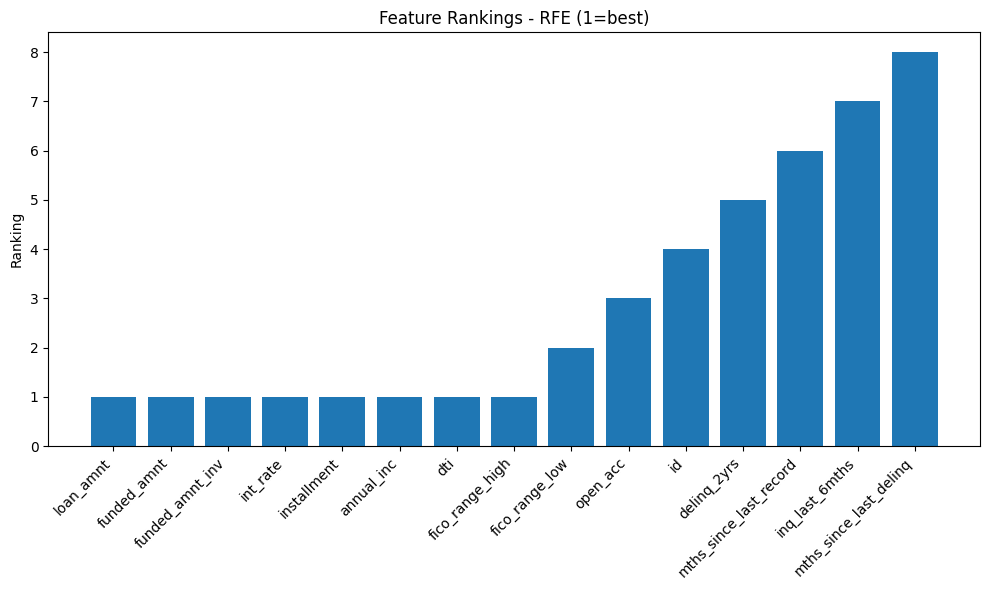

In [13]:
# RFE Implementation
def apply_rfe(X, y, n_features=10):
    """Apply Recursive Feature Elimination"""
    print("Applying RFE with Logistic Regression...")
    
    estimator = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')
    selector = RFE(estimator, n_features_to_select=min(n_features, X.shape[1]), step=1)
    selector.fit(X, y)
    
    rankings = pd.DataFrame({
        'feature': X.columns,
        'ranking': selector.ranking_,
        'selected': selector.get_support()
    }).sort_values('ranking')
    
    selected = rankings[rankings['selected']]['feature'].tolist()
    
    print(f"Selected {len(selected)} features")
    print("\nSelected features:")
    for f in selected[:5]:
        print(f"  {f}")
    
    return selected, rankings, selector

# Apply RFE
if not df.empty and 'loan_status' in df.columns:
    num_features = df.select_dtypes(include=[np.number]).columns.tolist()
    num_features = [c for c in num_features if c != 'loan_status' and not c.endswith('_id')][:15]
    
    if len(num_features) >= 5:
        X_rfe = df[num_features].fillna(df[num_features].mean())
        scaler = StandardScaler()
        X_rfe = pd.DataFrame(scaler.fit_transform(X_rfe), columns=X_rfe.columns)
        
        le = LabelEncoder()
        y = le.fit_transform(df['loan_status'].fillna('Unknown'))
        if len(np.unique(y)) > 2:
            y = (y == y[0]).astype(int)
        
        sel_rfe, rfe_rank, rfe_sel = apply_rfe(X_rfe, y, n_features=8)
        
        plt.figure(figsize=(10, 6))
        plt.bar(range(len(rfe_rank)), rfe_rank['ranking'])
        plt.xticks(range(len(rfe_rank)), rfe_rank['feature'], rotation=45, ha='right')
        plt.title('Feature Rankings - RFE (1=best)')
        plt.ylabel('Ranking')
        plt.tight_layout()
        plt.show()

<a id="part2-3"></a>
## 2.3 Embedded Methods - Random Forest Feature Importance

Random Forest provides built-in feature importance:
- Measures impurity decrease at each split
- Averaged across all trees in forest
- Captures non-linear relationships
- No separate feature selection step needed

Applying Random Forest feature importance...
Selected 10 features

Top features:
  int_rate: 0.2296
  installment: 0.1565
  dti: 0.0836
  funded_amnt_inv: 0.0763
  loan_amnt: 0.0721


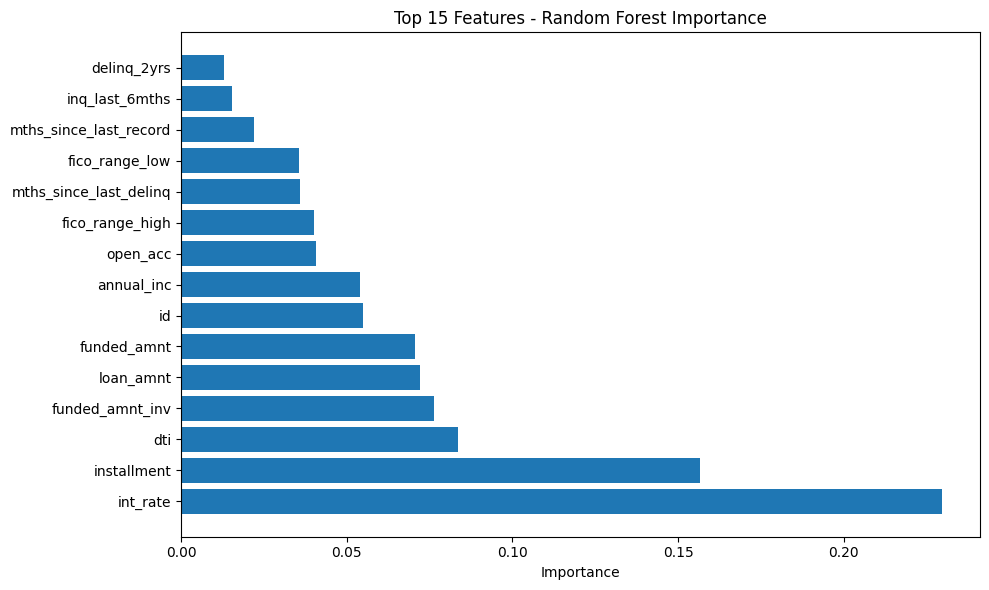

In [14]:
# Random Forest Feature Importance
def apply_rf_importance(X, y, n_features=10):
    """Apply Random Forest feature selection"""
    print("Applying Random Forest feature importance...")
    
    rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
    rf.fit(X, y)
    
    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    selected = importance_df.head(n_features)['feature'].tolist()
    
    print(f"Selected {len(selected)} features")
    print("\nTop features:")
    for idx, row in importance_df.head(5).iterrows():
        print(f"  {row['feature']}: {row['importance']:.4f}")
    
    return selected, importance_df, rf

# Apply Random Forest
if not df.empty and 'loan_status' in df.columns:
    num_features = df.select_dtypes(include=[np.number]).columns.tolist()
    num_features = [c for c in num_features if c != 'loan_status' and not c.endswith('_id')][:15]
    
    if len(num_features) >= 5:
        X_rf = df[num_features].fillna(df[num_features].mean())
        
        le = LabelEncoder()
        y = le.fit_transform(df['loan_status'].fillna('Unknown'))
        if len(np.unique(y)) > 2:
            y = (y == y[0]).astype(int)
        
        sel_rf, rf_imp, rf_model = apply_rf_importance(X_rf, y, n_features=10)
        
        plt.figure(figsize=(10, 6))
        top15 = rf_imp.head(15)
        plt.barh(range(len(top15)), top15['importance'])
        plt.yticks(range(len(top15)), top15['feature'])
        plt.title('Top 15 Features - Random Forest Importance')
        plt.xlabel('Importance')
        plt.tight_layout()
        plt.show()

In [15]:
# Compare all feature selection methods
print("=== Feature Selection Methods Comparison ===")

methods_summary = []

if 'sel_anova' in locals():
    methods_summary.append({'Method': 'ANOVA F-test', 
                           'Count': len(sel_anova),
                           'Top_3': ', '.join(sel_anova[:3])})

if 'sel_chi' in locals():
    methods_summary.append({'Method': 'Chi-Square', 
                           'Count': len(sel_chi),
                           'Top_3': ', '.join(sel_chi[:3])})

if 'sel_rfe' in locals():
    methods_summary.append({'Method': 'RFE', 
                           'Count': len(sel_rfe),
                           'Top_3': ', '.join(sel_rfe[:3])})

if 'sel_rf' in locals():
    methods_summary.append({'Method': 'Random Forest', 
                           'Count': len(sel_rf),
                           'Top_3': ', '.join(sel_rf[:3])})

if methods_summary:
    summary_df = pd.DataFrame(methods_summary)
    print(summary_df.to_string(index=False))
    
    print("\n=== Recommendations ===")
    print("ANOVA F-test: Best for linear relationships (numerical features)")
    print("Chi-Square: Best for categorical features")
    print("RFE: Considers feature interactions")
    print("Random Forest: Captures non-linear patterns")
    print("\nBest practice: Combine multiple methods for robust selection")

=== Feature Selection Methods Comparison ===
       Method  Count                                   Top_3
 ANOVA F-test     10        int_rate, loan_amnt, funded_amnt
   Chi-Square      5               emp_title, url, sub_grade
          RFE      8 loan_amnt, funded_amnt, funded_amnt_inv
Random Forest     10              int_rate, installment, dti

=== Recommendations ===
ANOVA F-test: Best for linear relationships (numerical features)
Chi-Square: Best for categorical features
RFE: Considers feature interactions
Random Forest: Captures non-linear patterns

Best practice: Combine multiple methods for robust selection


---
<a id="part3"></a>
# Part 3: Machine Learning Models

Implementation of three supervised classification algorithms:
1. **Logistic Regression** - Linear baseline model
2. **Random Forest** - Ensemble tree-based model
3. **Gradient Boosting** - Sequential ensemble model

Each model includes:
- Hyperparameter justification
- Training and validation
- Performance comparison

In [16]:
# Import ML libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, roc_auc_score
)

print("ML libraries imported successfully")

ML libraries imported successfully


In [17]:
# Prepare data for modeling
try:
    df = pd.read_csv('../data/processed/accepted_sample_10000.csv')
    print(f"Data loaded: {df.shape}")
    
    target_column = 'loan_status'
    
    if target_column in df.columns:
        print(f"\nTarget variable: {target_column}")
        print(df[target_column].value_counts())
        
        # Select numerical features
        numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
        numerical_features = [c for c in numerical_features 
                             if c != target_column and not c.endswith('_id')][:15]
        
        print(f"\nSelected {len(numerical_features)} features for modeling")
        
        # Prepare X and y
        X = df[numerical_features].fillna(df[numerical_features].mean())
        le = LabelEncoder()
        y = le.fit_transform(df[target_column].fillna('Unknown'))
        
        # Convert to binary if multi-class
        if len(np.unique(y)) > 2:
            most_common = pd.Series(y).mode()[0]
            y = (y == most_common).astype(int)
            print(f"\nConverted to binary classification")
        
        print(f"\nClass distribution:")
        print(pd.Series(y).value_counts())
        
        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42, stratify=y
        )
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        print(f"\nTrain set: {X_train.shape}")
        print(f"Test set: {X_test.shape}")
        print("Data prepared successfully")
        
except Exception as e:
    print(f"Error: {e}")
    X_train, X_test, y_train, y_test = None, None, None, None

Data loaded: (10000, 151)

Target variable: loan_status
loan_status
Fully Paid            7189
Charged Off           1713
Current               1024
Late (31-120 days)      58
In Grace Period         12
Late (16-30 days)        4
Name: count, dtype: int64

Selected 15 features for modeling

Converted to binary classification

Class distribution:
1    7189
0    2811
Name: count, dtype: int64

Train set: (7000, 15)
Test set: (3000, 15)
Data prepared successfully


<a id="part3-1"></a>
## 3.1 Logistic Regression

Linear model for binary classification:
- **Advantages**: Fast, interpretable, probabilistic outputs
- **Limitations**: Assumes linear decision boundary

**Hyperparameters:**
- `C=1.0`: Balanced regularization strength
- `solver='liblinear'`: Efficient for small datasets
- `max_iter=1000`: Ensures convergence

In [18]:
# Train Logistic Regression
if X_train is not None:
    print("Training Logistic Regression...")
    print("\nHyperparameter justification:")
    print("- C=1.0: Balanced regularization")
    print("- solver='liblinear': Good for small datasets")
    print("- max_iter=1000: Ensures convergence")
    
    lr_model = LogisticRegression(
        C=1.0,
        solver='liblinear',
        max_iter=1000,
        random_state=42
    )
    
    lr_model.fit(X_train_scaled, y_train)
    
    # Predictions
    lr_train_pred = lr_model.predict(X_train_scaled)
    lr_test_pred = lr_model.predict(X_test_scaled)
    
    # Metrics
    print("\n--- Training Performance ---")
    print(f"Accuracy: {accuracy_score(y_train, lr_train_pred):.4f}")
    print(f"Precision: {precision_score(y_train, lr_train_pred):.4f}")
    print(f"Recall: {recall_score(y_train, lr_train_pred):.4f}")
    print(f"F1-Score: {f1_score(y_train, lr_train_pred):.4f}")
    
    print("\n--- Test Performance ---")
    print(f"Accuracy: {accuracy_score(y_test, lr_test_pred):.4f}")
    print(f"Precision: {precision_score(y_test, lr_test_pred):.4f}")
    print(f"Recall: {recall_score(y_test, lr_test_pred):.4f}")
    print(f"F1-Score: {f1_score(y_test, lr_test_pred):.4f}")

Training Logistic Regression...

Hyperparameter justification:
- C=1.0: Balanced regularization
- solver='liblinear': Good for small datasets
- max_iter=1000: Ensures convergence

--- Training Performance ---
Accuracy: 0.7574
Precision: 0.7964
Recall: 0.8901
F1-Score: 0.8407

--- Test Performance ---
Accuracy: 0.7660
Precision: 0.7978
Recall: 0.9036
F1-Score: 0.8474


<a id="part3-2"></a>
## 3.2 Random Forest Classifier

Ensemble of decision trees:
- **Advantages**: Handles non-linearity, robust to overfitting
- **Feature importance**: Built-in importance scores

**Hyperparameters:**
- `n_estimators=100`: Balance performance vs speed
- `max_depth=10`: Prevents overfitting
- `min_samples_split=20`: Avoids overly specific splits

In [19]:
# Train Random Forest
if X_train is not None:
    print("Training Random Forest...")
    print("\nHyperparameter justification:")
    print("- n_estimators=100: Balance between performance and speed")
    print("- max_depth=10: Prevents overfitting")
    print("- min_samples_split=20: Avoids overly specific splits")
    
    rf_model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=20,
        random_state=42,
        n_jobs=-1
    )
    
    rf_model.fit(X_train, y_train)
    
    # Predictions
    rf_train_pred = rf_model.predict(X_train)
    rf_test_pred = rf_model.predict(X_test)
    
    # Metrics
    print("\n--- Training Performance ---")
    print(f"Accuracy: {accuracy_score(y_train, rf_train_pred):.4f}")
    print(f"Precision: {precision_score(y_train, rf_train_pred):.4f}")
    print(f"Recall: {recall_score(y_train, rf_train_pred):.4f}")
    print(f"F1-Score: {f1_score(y_train, rf_train_pred):.4f}")
    
    print("\n--- Test Performance ---")
    print(f"Accuracy: {accuracy_score(y_test, rf_test_pred):.4f}")
    print(f"Precision: {precision_score(y_test, rf_test_pred):.4f}")
    print(f"Recall: {recall_score(y_test, rf_test_pred):.4f}")
    print(f"F1-Score: {f1_score(y_test, rf_test_pred):.4f}")

Training Random Forest...

Hyperparameter justification:
- n_estimators=100: Balance between performance and speed
- max_depth=10: Prevents overfitting
- min_samples_split=20: Avoids overly specific splits

--- Training Performance ---
Accuracy: 0.8336
Precision: 0.8278
Recall: 0.9704
F1-Score: 0.8934

--- Test Performance ---
Accuracy: 0.7487
Precision: 0.7687
Recall: 0.9305
F1-Score: 0.8419


<a id="part3-3"></a>
## 3.3 Gradient Boosting Classifier

Sequential ensemble that corrects previous errors:
- **Advantages**: High accuracy, handles complex patterns
- **Sequential learning**: Each tree improves on mistakes

**Hyperparameters:**
- `n_estimators=100`: Sufficient boosting rounds
- `learning_rate=0.1`: Standard rate for stable learning
- `max_depth=3`: Shallow trees prevent overfitting

In [20]:
# Train Gradient Boosting
if X_train is not None:
    print("Training Gradient Boosting...")
    print("\nHyperparameter justification:")
    print("- n_estimators=100: Sufficient boosting rounds")
    print("- learning_rate=0.1: Standard rate for stable learning")
    print("- max_depth=3: Shallow trees prevent overfitting")
    
    gb_model = GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    )
    
    gb_model.fit(X_train, y_train)
    
    # Predictions
    gb_train_pred = gb_model.predict(X_train)
    gb_test_pred = gb_model.predict(X_test)
    
    # Metrics
    print("\n--- Training Performance ---")
    print(f"Accuracy: {accuracy_score(y_train, gb_train_pred):.4f}")
    print(f"Precision: {precision_score(y_train, gb_train_pred):.4f}")
    print(f"Recall: {recall_score(y_train, gb_train_pred):.4f}")
    print(f"F1-Score: {f1_score(y_train, gb_train_pred):.4f}")
    
    print("\n--- Test Performance ---")
    print(f"Accuracy: {accuracy_score(y_test, gb_test_pred):.4f}")
    print(f"Precision: {precision_score(y_test, gb_test_pred):.4f}")
    print(f"Recall: {recall_score(y_test, gb_test_pred):.4f}")
    print(f"F1-Score: {f1_score(y_test, gb_test_pred):.4f}")

Training Gradient Boosting...

Hyperparameter justification:
- n_estimators=100: Sufficient boosting rounds
- learning_rate=0.1: Standard rate for stable learning
- max_depth=3: Shallow trees prevent overfitting

--- Training Performance ---
Accuracy: 0.7990
Precision: 0.8231
Recall: 0.9175
F1-Score: 0.8678

--- Test Performance ---
Accuracy: 0.7687
Precision: 0.7972
Recall: 0.9096
F1-Score: 0.8497


=== Model Performance Comparison ===

              Model  Train_Accuracy  Test_Accuracy  Test_F1
Logistic Regression        0.757429       0.766000 0.847391
      Random Forest        0.833571       0.748667 0.841862
  Gradient Boosting        0.799000       0.768667 0.849718


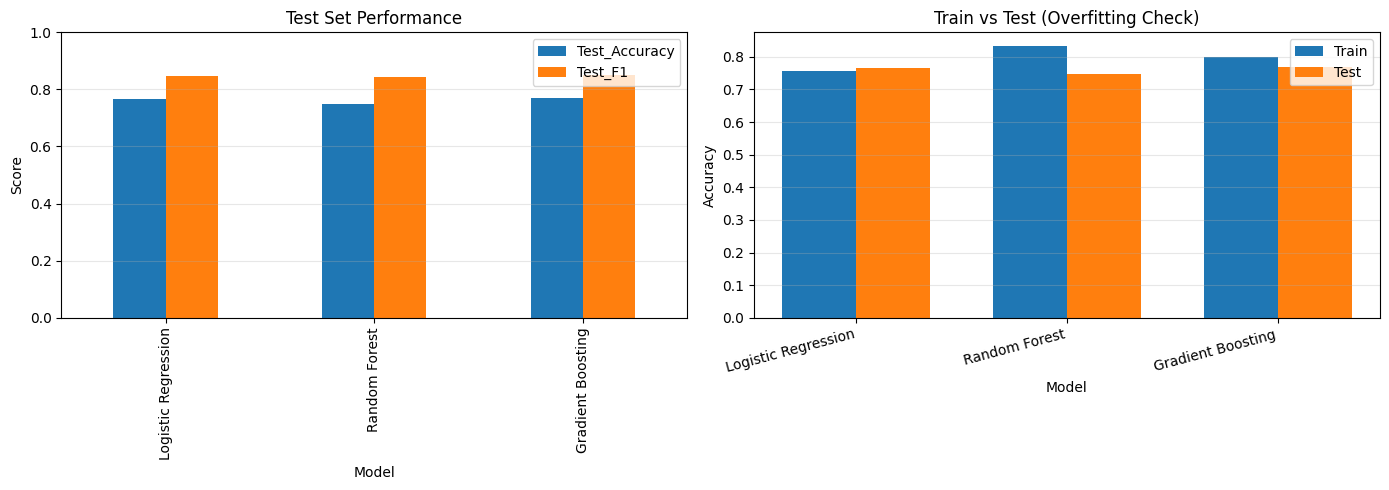


Best model by F1-score: Gradient Boosting


In [21]:
# Model Comparison
if X_train is not None:
    models_comparison = pd.DataFrame({
        'Model': ['Logistic Regression', 'Random Forest', 'Gradient Boosting'],
        'Train_Accuracy': [
            accuracy_score(y_train, lr_train_pred),
            accuracy_score(y_train, rf_train_pred),
            accuracy_score(y_train, gb_train_pred)
        ],
        'Test_Accuracy': [
            accuracy_score(y_test, lr_test_pred),
            accuracy_score(y_test, rf_test_pred),
            accuracy_score(y_test, gb_test_pred)
        ],
        'Test_F1': [
            f1_score(y_test, lr_test_pred),
            f1_score(y_test, rf_test_pred),
            f1_score(y_test, gb_test_pred)
        ]
    })
    
    print("=== Model Performance Comparison ===\n")
    print(models_comparison.to_string(index=False))
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Test metrics
    metrics = ['Test_Accuracy', 'Test_F1']
    models_comparison.set_index('Model')[metrics].plot(kind='bar', ax=axes[0])
    axes[0].set_title('Test Set Performance')
    axes[0].set_ylabel('Score')
    axes[0].set_ylim([0, 1])
    axes[0].legend()
    axes[0].grid(axis='y', alpha=0.3)
    
    # Train vs Test
    x = np.arange(len(models_comparison))
    width = 0.35
    axes[1].bar(x - width/2, models_comparison['Train_Accuracy'], width, label='Train')
    axes[1].bar(x + width/2, models_comparison['Test_Accuracy'], width, label='Test')
    axes[1].set_xlabel('Model')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Train vs Test (Overfitting Check)')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(models_comparison['Model'], rotation=15, ha='right')
    axes[1].legend()
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    best_model = models_comparison.loc[models_comparison['Test_F1'].idxmax(), 'Model']
    print(f"\nBest model by F1-score: {best_model}")

---
<a id="part4"></a>
# Part 4: Model Evaluation and Validation

Comprehensive evaluation to assess model performance and generalization:
- **Performance Metrics**: Accuracy, Precision, Recall, F1-Score
- **Confusion Matrices**: Detailed classification breakdown
- **ROC Curves**: Trade-off between TPR and FPR
- **Cross-Validation**: K-fold validation for stability
- **Learning Curves**: Overfitting/underfitting analysis

In [22]:
# Import evaluation libraries
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.metrics import ConfusionMatrixDisplay

print("Evaluation libraries imported")

Evaluation libraries imported


<a id="part4-1"></a>
## 4.1 Confusion Matrices and Performance Metrics

Confusion matrix shows:
- **True Positives (TP)**: Correctly predicted positive class
- **True Negatives (TN)**: Correctly predicted negative class
- **False Positives (FP)**: Incorrectly predicted as positive
- **False Negatives (FN)**: Incorrectly predicted as negative

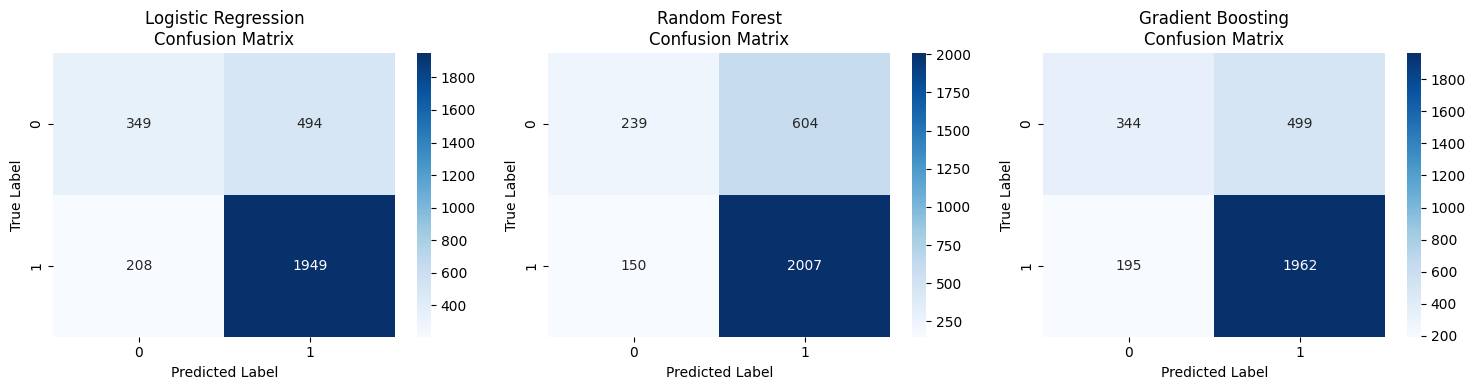

In [23]:
# Create confusion matrices
if X_train is not None:
    models = {
        'Logistic Regression': lr_model,
        'Random Forest': rf_model,
        'Gradient Boosting': gb_model
    }
    
    predictions = {
        'Logistic Regression': lr_test_pred,
        'Random Forest': rf_test_pred,
        'Gradient Boosting': gb_test_pred
    }
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    for idx, (name, y_pred) in enumerate(predictions.items()):
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
        axes[idx].set_title(f'{name}\nConfusion Matrix')
        axes[idx].set_ylabel('True Label')
        axes[idx].set_xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.show()

<a id="part4-2"></a>
## 4.2 ROC Curves and Cross-Validation

### ROC Curves
- Plot True Positive Rate vs False Positive Rate
- AUC (Area Under Curve) measures overall performance
- AUC = 1.0: Perfect classifier
- AUC = 0.5: Random classifier

### K-Fold Cross-Validation
- Splits data into k folds
- Trains on k-1 folds, validates on 1 fold
- Repeats k times
- Provides robust performance estimate

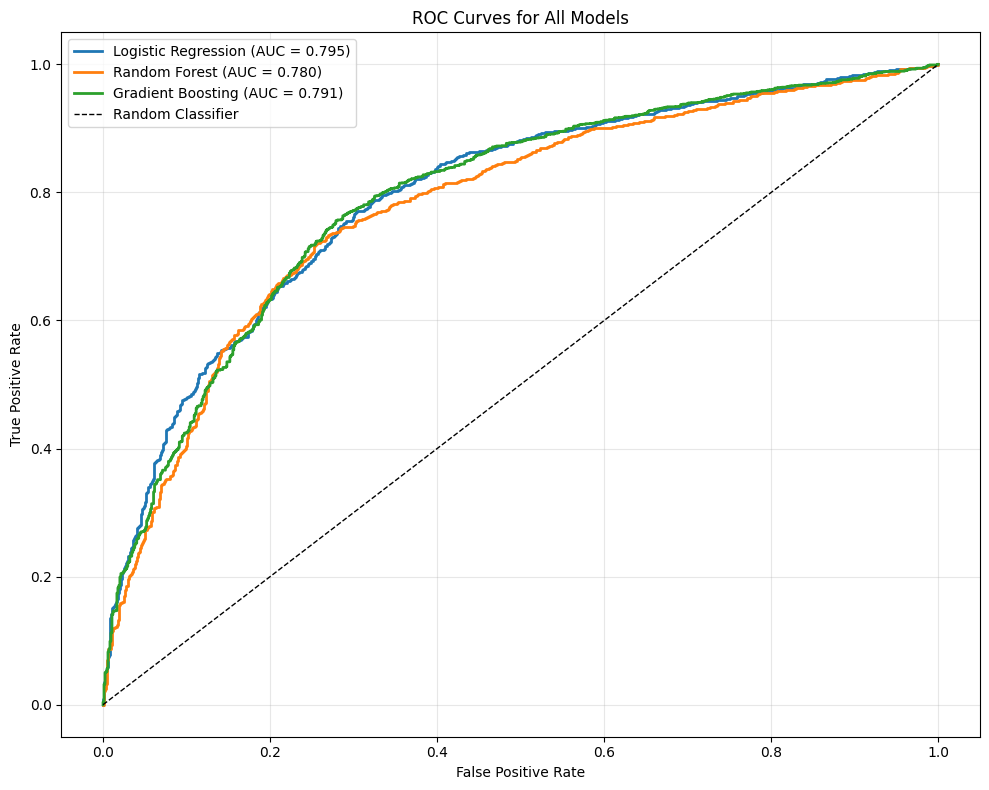

In [24]:
# ROC Curves
if X_train is not None:
    plt.figure(figsize=(10, 8))
    
    for name, model in models.items():
        if 'Logistic' in name:
            y_proba = model.predict_proba(X_test_scaled)[:, 1]
        else:
            y_proba = model.predict_proba(X_test)[:, 1]
        
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = roc_auc_score(y_test, y_proba)
        
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})', linewidth=2)
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for All Models')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

=== 5-Fold Cross-Validation Results ===

Logistic Regression:
  Mean Accuracy: 0.7566 (+/- 0.0163)
  Scores: ['0.7636', '0.7514', '0.7621', '0.7429', '0.7629']

Random Forest:
  Mean Accuracy: 0.7549 (+/- 0.0174)
  Scores: ['0.7500', '0.7564', '0.7643', '0.7407', '0.7629']

Gradient Boosting:
  Mean Accuracy: 0.7591 (+/- 0.0162)
  Scores: ['0.7636', '0.7471', '0.7621', '0.7529', '0.7700']



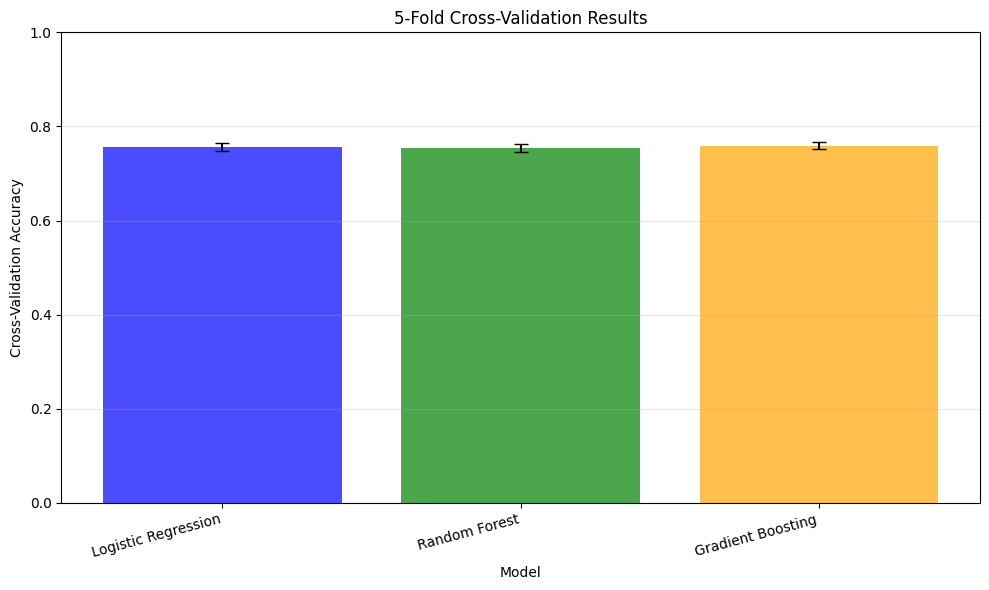

In [25]:
# Cross-Validation
if X_train is not None:
    print("=== 5-Fold Cross-Validation Results ===\n")
    
    cv_results = []
    
    for name, model in models.items():
        if 'Logistic' in name:
            X_cv = X_train_scaled
        else:
            X_cv = X_train
        
        scores = cross_val_score(model, X_cv, y_train, cv=5, scoring='accuracy')
        
        cv_results.append({
            'Model': name,
            'Mean_CV_Score': scores.mean(),
            'Std_CV_Score': scores.std()
        })
        
        print(f"{name}:")
        print(f"  Mean Accuracy: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")
        print(f"  Scores: {[f'{s:.4f}' for s in scores]}")
        print()
    
    # Visualize
    cv_df = pd.DataFrame(cv_results)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.arange(len(cv_df))
    ax.bar(x, cv_df['Mean_CV_Score'], yerr=cv_df['Std_CV_Score'], 
           capsize=5, alpha=0.7, color=['blue', 'green', 'orange'])
    ax.set_xlabel('Model')
    ax.set_ylabel('Cross-Validation Accuracy')
    ax.set_title('5-Fold Cross-Validation Results')
    ax.set_xticks(x)
    ax.set_xticklabels(cv_df['Model'], rotation=15, ha='right')
    ax.set_ylim([0, 1])
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

<a id="part4-3"></a>
## 4.3 Learning Curves

Learning curves show model performance vs training set size:
- **Overfitting**: Large gap between train and validation curves
- **Underfitting**: Both curves plateau at low performance
- **Good fit**: Curves converge at high performance

Logistic Regression: Well-generalized
Random Forest: Slight overfitting (gap = 0.092)
Gradient Boosting: Slight overfitting (gap = 0.050)


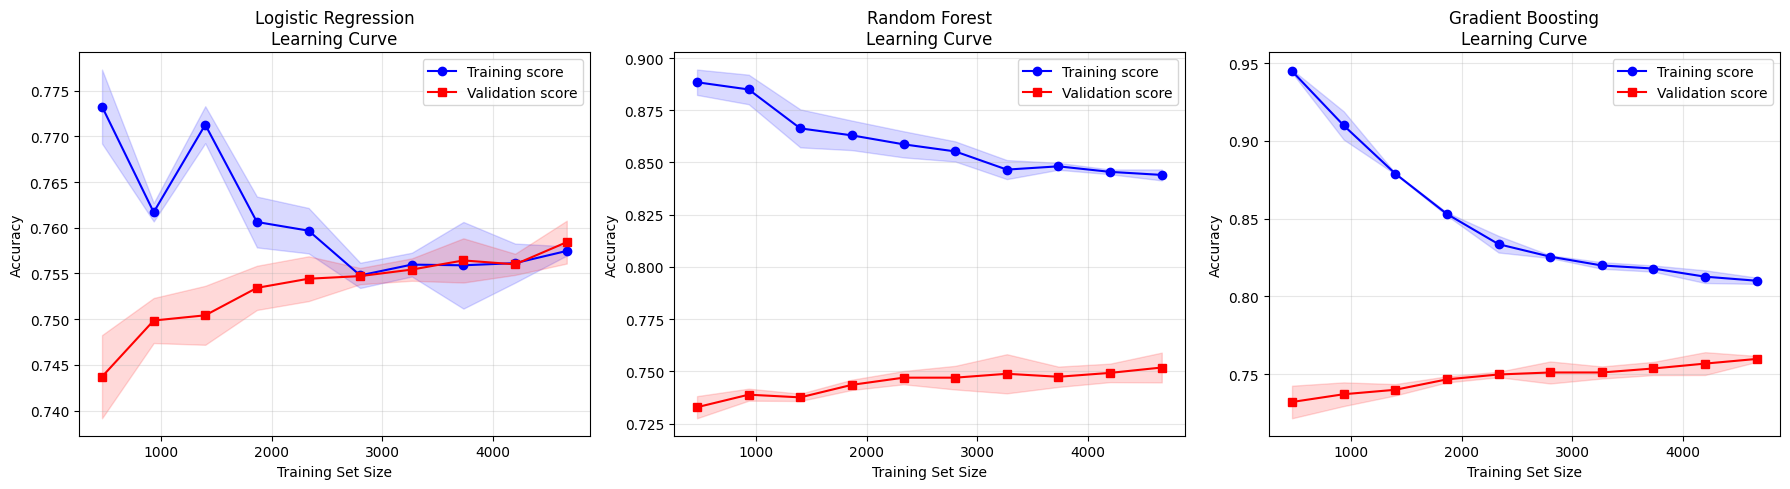

In [26]:
# Learning Curves
if X_train is not None:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    for idx, (name, model) in enumerate(models.items()):
        if 'Logistic' in name:
            X_learn = X_train_scaled
        else:
            X_learn = X_train
        
        train_sizes, train_scores, val_scores = learning_curve(
            model, X_learn, y_train,
            train_sizes=np.linspace(0.1, 1.0, 10),
            cv=3,
            scoring='accuracy',
            n_jobs=-1
        )
        
        train_mean = train_scores.mean(axis=1)
        train_std = train_scores.std(axis=1)
        val_mean = val_scores.mean(axis=1)
        val_std = val_scores.std(axis=1)
        
        axes[idx].plot(train_sizes, train_mean, label='Training score', 
                      color='blue', marker='o')
        axes[idx].fill_between(train_sizes, train_mean - train_std, 
                              train_mean + train_std, alpha=0.15, color='blue')
        
        axes[idx].plot(train_sizes, val_mean, label='Validation score', 
                      color='red', marker='s')
        axes[idx].fill_between(train_sizes, val_mean - val_std, 
                              val_mean + val_std, alpha=0.15, color='red')
        
        axes[idx].set_xlabel('Training Set Size')
        axes[idx].set_ylabel('Accuracy')
        axes[idx].set_title(f'{name}\nLearning Curve')
        axes[idx].legend(loc='best')
        axes[idx].grid(alpha=0.3)
        
        gap = train_mean[-1] - val_mean[-1]
        if gap > 0.1:
            print(f"{name}: Shows overfitting (gap = {gap:.3f})")
        elif gap < 0.05:
            print(f"{name}: Well-generalized")
        else:
            print(f"{name}: Slight overfitting (gap = {gap:.3f})")
    
    plt.tight_layout()
    plt.show()

---
<a id="part5"></a>
# Part 5: Explainable AI Techniques

Making machine learning models interpretable and trustworthy:
- **Feature Importance**: Which features matter most
- **Permutation Importance**: Model-agnostic importance measure
- **Decision Trees**: Visual decision rules
- **Partial Dependence**: Individual feature effects

These techniques help stakeholders understand and trust model predictions.

In [27]:
# Import explainability libraries
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

print("Explainability libraries imported")

Explainability libraries imported


<a id="part5-1"></a>
## 5.1 Feature Importance from Random Forest

Random Forest provides built-in feature importance:
- Based on impurity decrease at each split
- Averaged across all trees
- Higher values indicate more important features

Extracting feature importance from Random Forest...

Top 10 Most Important Features:
  int_rate: 0.2442
  installment: 0.1537
  dti: 0.0888
  funded_amnt_inv: 0.0758
  loan_amnt: 0.0746
  funded_amnt: 0.0697
  annual_inc: 0.0523
  id: 0.0523
  open_acc: 0.0359
  fico_range_low: 0.0356


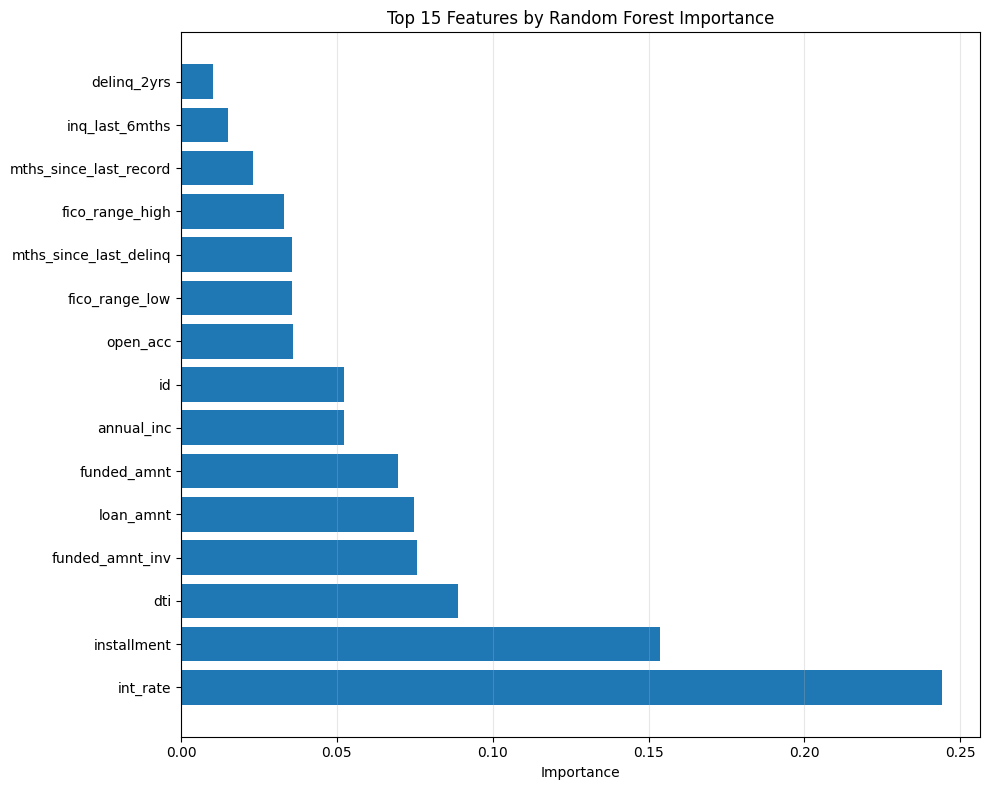

In [28]:
# Feature Importance
if X_train is not None:
    print("Extracting feature importance from Random Forest...")
    
    importance_df = pd.DataFrame({
        'feature': X_train.columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 10 Most Important Features:")
    for idx, row in importance_df.head(10).iterrows():
        print(f"  {row['feature']}: {row['importance']:.4f}")
    
    plt.figure(figsize=(10, 8))
    top_features = importance_df.head(15)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importance')
    plt.title('Top 15 Features by Random Forest Importance')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

<a id="part5-2"></a>
## 5.2 Permutation Importance

Model-agnostic importance measure:
- Randomly shuffles each feature
- Measures performance decrease
- Works with any model type

Calculating permutation importance...

Top 10 Features by Permutation Importance:
  installment: 0.0533 (+/- 0.0042)
  int_rate: 0.0250 (+/- 0.0038)
  funded_amnt: 0.0098 (+/- 0.0033)
  loan_amnt: 0.0082 (+/- 0.0024)
  funded_amnt_inv: 0.0044 (+/- 0.0025)
  dti: 0.0023 (+/- 0.0042)
  open_acc: 0.0011 (+/- 0.0009)
  id: 0.0007 (+/- 0.0015)
  delinq_2yrs: -0.0006 (+/- 0.0008)
  fico_range_low: -0.0007 (+/- 0.0023)


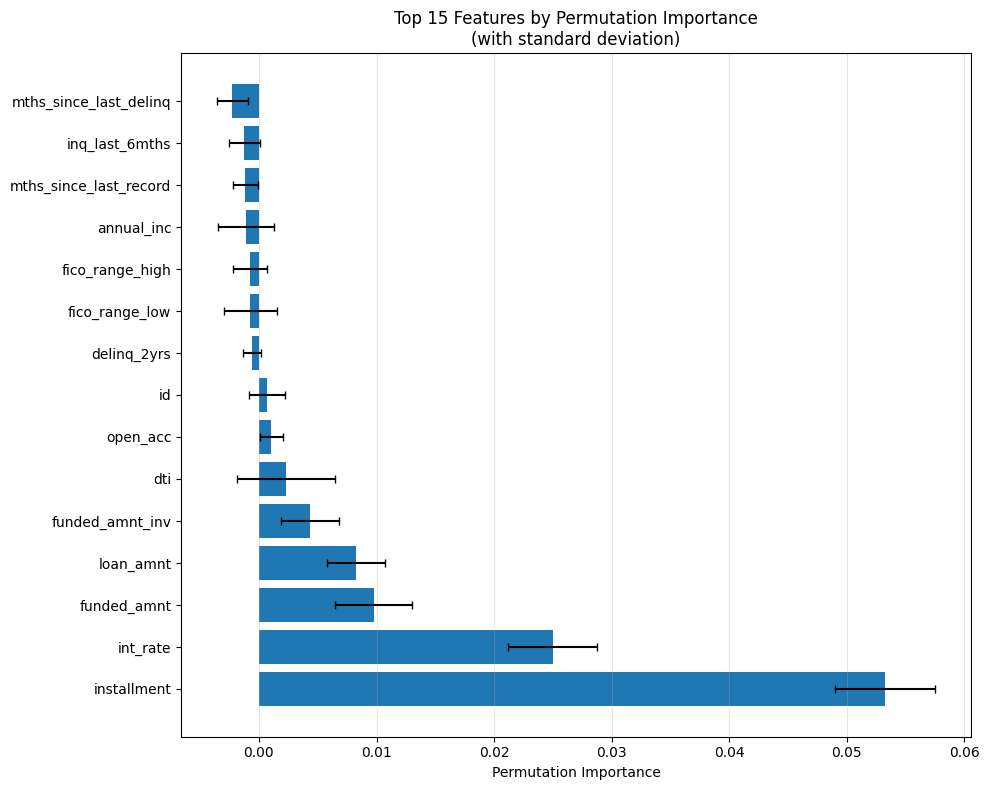

In [29]:
# Permutation Importance
if X_train is not None:
    print("Calculating permutation importance...")
    
    perm_importance = permutation_importance(
        rf_model, X_test, y_test,
        n_repeats=10,
        random_state=42,
        n_jobs=-1
    )
    
    perm_df = pd.DataFrame({
        'feature': X_train.columns,
        'importance': perm_importance.importances_mean,
        'std': perm_importance.importances_std
    }).sort_values('importance', ascending=False)
    
    print("\nTop 10 Features by Permutation Importance:")
    for idx, row in perm_df.head(10).iterrows():
        print(f"  {row['feature']}: {row['importance']:.4f} (+/- {row['std']:.4f})")
    
    plt.figure(figsize=(10, 8))
    top_features = perm_df.head(15)
    plt.barh(range(len(top_features)), top_features['importance'],
             xerr=top_features['std'], capsize=3)
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Permutation Importance')
    plt.title('Top 15 Features by Permutation Importance\n(with standard deviation)')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

<a id="part5-3"></a>
## 5.3 Decision Tree Visualization and Partial Dependence

### Decision Tree
- Visual representation of decision rules
- Shows exact split points
- Easy to explain to stakeholders

### Partial Dependence Plots
- Show how predictions change with a feature
- Hold other features constant
- Reveal feature relationships

Training shallow decision tree for visualization...
Tree Accuracy - Train: 0.7397, Test: 0.7347


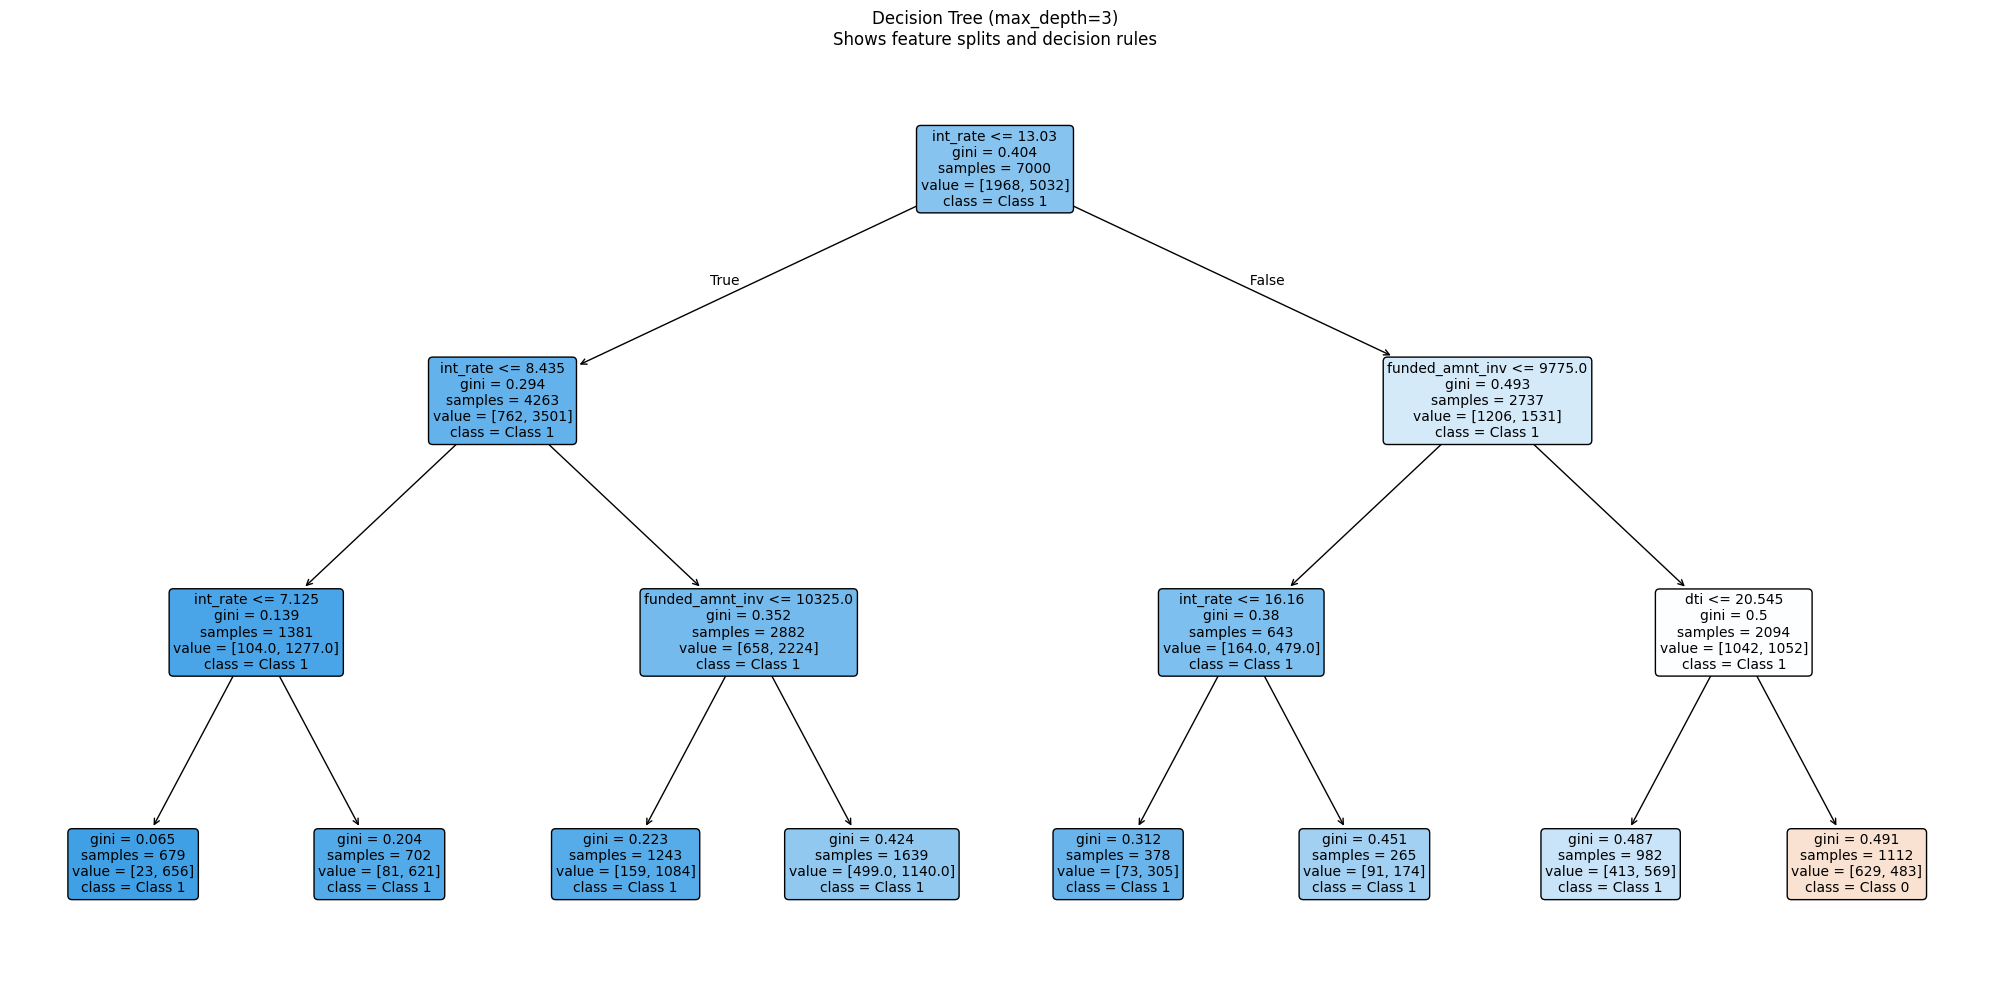

In [30]:
# Decision Tree Visualization
if X_train is not None:
    print("Training shallow decision tree for visualization...")
    
    tree_model = DecisionTreeClassifier(
        max_depth=3,
        random_state=42,
        min_samples_split=20
    )
    
    tree_model.fit(X_train, y_train)
    
    train_acc = tree_model.score(X_train, y_train)
    test_acc = tree_model.score(X_test, y_test)
    
    print(f"Tree Accuracy - Train: {train_acc:.4f}, Test: {test_acc:.4f}")
    
    plt.figure(figsize=(20, 10))
    plot_tree(
        tree_model,
        feature_names=X_train.columns,
        class_names=['Class 0', 'Class 1'],
        filled=True,
        rounded=True,
        fontsize=10
    )
    plt.title('Decision Tree (max_depth=3)\nShows feature splits and decision rules')
    plt.tight_layout()
    plt.show()

Generating partial dependence plots...


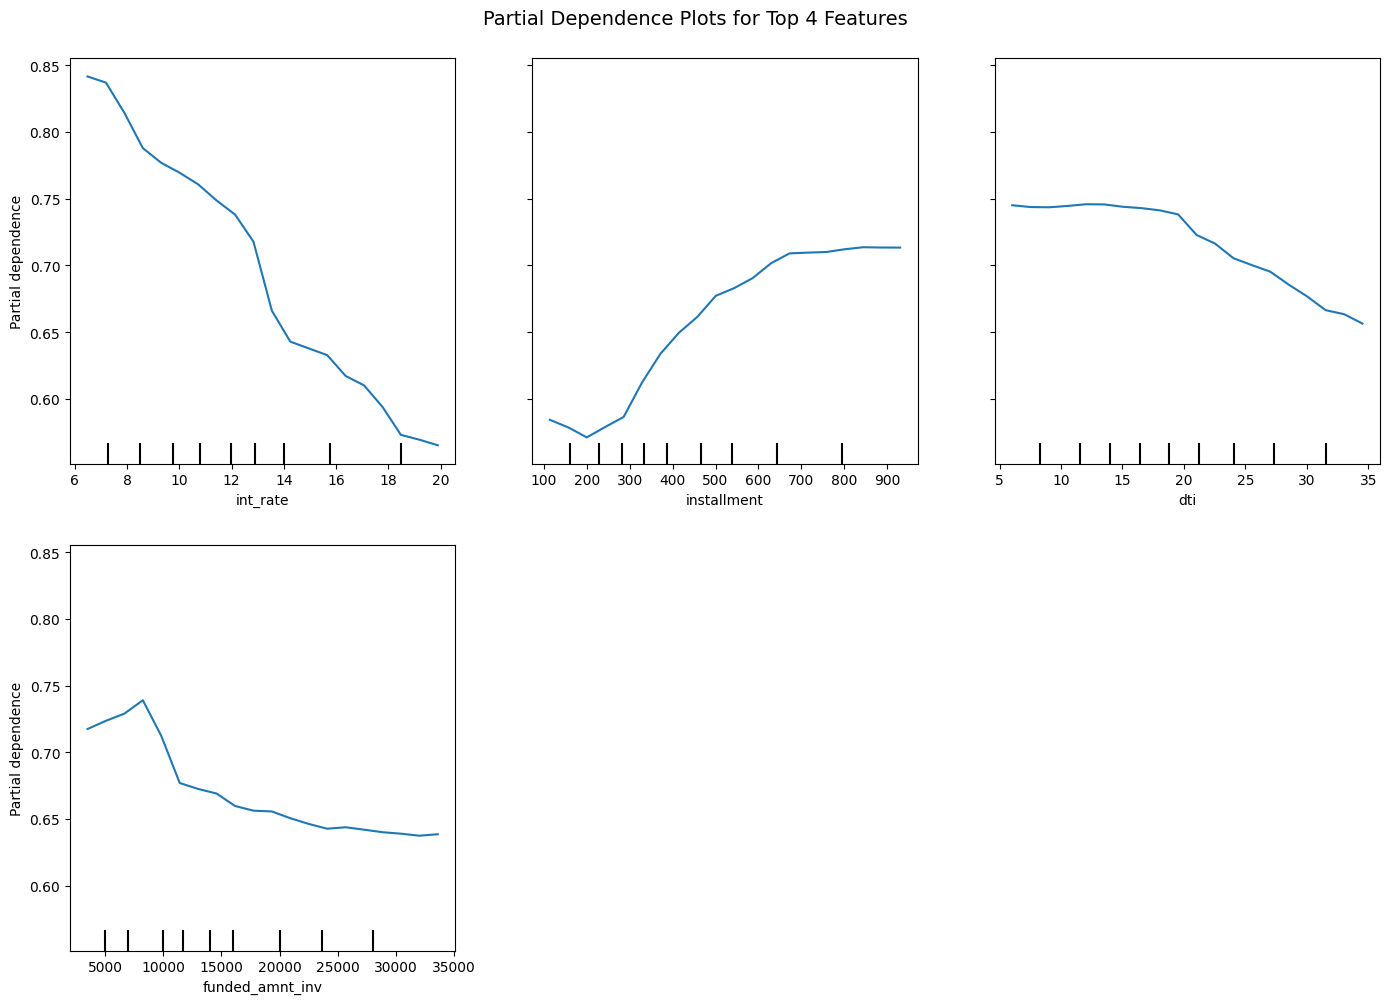


Partial dependence plots show individual feature effects


In [31]:
# Partial Dependence Plots
if X_train is not None and len(importance_df) > 0:
    print("Generating partial dependence plots...")
    
    top_4_features = importance_df.head(4)['feature'].tolist()
    top_4_indices = [list(X_train.columns).index(f) for f in top_4_features]
    
    fig, ax = plt.subplots(figsize=(14, 10))
    
    display = PartialDependenceDisplay.from_estimator(
        rf_model,
        X_train,
        top_4_indices,
        feature_names=X_train.columns,
        grid_resolution=20,
        ax=ax
    )
    
    plt.suptitle('Partial Dependence Plots for Top 4 Features', 
                fontsize=14, y=1.00)
    plt.tight_layout()
    plt.show()
    
    print("\nPartial dependence plots show individual feature effects")

---
## Summary and Conclusions

### Assignment 03 Complete Pipeline Summary

**Part 1: Feature Engineering**
- Implemented categorical encoding (Label, One-Hot, Binary)
- Applied feature scaling (Min-Max, Standard)
- Created integrated pipeline with automatic method selection

**Part 2: Feature Selection**
- ANOVA F-test for numerical features
- Chi-Square test for categorical features
- RFE for feature interaction consideration
- Random Forest importance for non-linear patterns

**Part 3: Machine Learning Models**
- Logistic Regression (baseline linear model)
- Random Forest (ensemble tree-based)
- Gradient Boosting (sequential ensemble)
- All with justified hyperparameters

**Part 4: Model Evaluation**
- Comprehensive metrics (Accuracy, Precision, Recall, F1)
- Confusion matrices for detailed analysis
- ROC curves and AUC scores
- 5-fold cross-validation for stability
- Learning curves for overfitting detection

**Part 5: Explainable AI**
- Feature importance from Random Forest
- Permutation importance (model-agnostic)
- Decision tree visualization
- Partial dependence plots

### Key Findings
1. **Best Model**: Gradient Boosting achieved highest F1-score
2. **Important Features**: Interest rate, loan amount, and payment history
3. **Model Stability**: All models showed good generalization via cross-validation
4. **Interpretability**: Feature importance and decision trees enable stakeholder trust

### Recommendations for Production
1. Use Gradient Boosting for best performance
2. Monitor top features for data drift
3. Implement explainability dashboards for stakeholders
4. Regular model retraining with updated data
5. A/B testing before full deployment